Useful Links:  
    - <https://peps.python.org/pep-0008/>  
    - <https://huggingface.co/blog/audio-datasets>  
    - <https://www.ffmpeg.org/download.html>, <https://www.geeksforgeeks.org/how-to-install-ffmpeg-on-windows/>

## Installments

In [ ]:
#%pip install autopep8

#%pip install pyarrow
#%pip install git+https://github.com/openai/whisper.git
#%pip install jiwer
#%pip install num2words
#%pip install -U pip setuptools wheel
#%pip install -U spacy

#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm

In [ ]:
%pip freeze

## Imports

In [1]:
import pandas as pd
import json

import numpy as np
from math import floor
from collections import Counter
import os
import wave
import random

from num2words import num2words
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import spacy

nltk.download('punkt')
nltk.download('stopwords')
nltk.download("averaged_perceptron_tagger")

import whisper
import jiwer

import eyed3

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
nlp_en = spacy.load("en_core_web_sm")
nlp_de = spacy.load("de_core_news_sm")

## Path

In [3]:
script_dir = os.getcwd()

## Major Functions

In [4]:
# Function to calculate the Jaro Similarity of two strings,
# contributed by AnkitRai01 at https://www.geeksforgeeks.org/jaro-and-jaro-winkler-similarity/
def jaro_distance(s1, s2):
    # If the strings are equal
    if (s1 == s2):
        return 1.0

    # Length of two strings
    len1 = len(s1)
    len2 = len(s2)

    if (len1 == 0 or len2 == 0):
        return 0.0

    # Maximum distance upto which matching
    # is allowed
    max_dist = (max(len(s1), len(s2)) // 2 ) - 1

    # Count of matches
    match = 0

    # Hash for matches
    hash_s1 = [0] * len(s1)
    hash_s2 = [0] * len(s2)

    # Traverse through the first string
    for i in range(len1):

        # Check if there is any matches
        for j in range( max(0, i - max_dist), min(len2, i + max_dist + 1)):

            # If there is a match
            if (s1[i] == s2[j] and hash_s2[j] == 0):
                hash_s1[i] = 1
                hash_s2[j] = 1
                match += 1
                break

    # If there is no match
    if (match == 0):
        return 0.0

    # Number of transpositions
    t = 0
    point = 0

    # Count number of occurrences
    # where two characters match but
    # there is a third matched character
    # in between the indices
    for i in range(len1):
        if (hash_s1[i]):

            # Find the next matched character
            # in second string
            while (hash_s2[point] == 0):
                point += 1

            if (s1[i] != s2[point]):
                point += 1
                t += 1
            else:
                point += 1
        t /= 2

    # Return the Jaro Similarity
    return ((match / len1 + match / len2 + (match - t) / match ) / 3.0)

# Jaro Winkler Similarity
def jaro_Winkler(s1, s2):

    jaro_dist = jaro_distance(s1, s2)

    # If the jaro Similarity is above a threshold
    if (jaro_dist > 0.7):

        # Find the length of common prefix
        prefix = 0

        for i in range(min(len(s1), len(s2))):

            # If the characters match
            if (s1[i] == s2[i]):
                prefix += 1

            # Else break
            else:
                break

        # Maximum of 4 characters are allowed in prefix
        prefix = min(4, prefix)

        # Calculate jaro winkler Similarity
        jaro_dist += 0.1 * prefix * (1 - jaro_dist)

    return jaro_dist


# function to normalize text with the option to remove stop words and lemmatize text
# it also turn numbers into words
def normalize_text(text, lang="en", remove_stopwords=True, add_common_stop_words=False, lemmatize=False):
    # Additional stop words from gigaspeech dataset
    disfluencies = {'uh', 'uhh', 'um', 'eh', 'mm', 'hm', 'ah', 'huh', 'ha', 'er'}
    
    # special strings related to gigaspeech dataset
    special_strings = {'<COMMA>', '<PERIOD>', '<QUESTIONMARK>', '<QUESTIONPOINT>', '<EXCLAMATIONMARK>', '<EXCLAMATIONPOINT>', '“', '„', '’'}
   
    # create pattern to match special_strings and remove them  
    pattern = '|'.join(map(re.escape, special_strings))
    text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    # Tokenization: Split the text into words or tokens
    words = word_tokenize(text)

    # Create a set of punctuation characters to remove
    punctuation = string.punctuation

    # Create a translation table to remove punctuation
    translator = str.maketrans('', '', punctuation)

    if remove_stopwords:
        # Remove stopwords if requested
        stop_words = disfluencies
        if add_common_stop_words:
            if lang == "en":
                stop_words.update(stopwords.words('english'))
            elif lang == "de":
                stop_words.update(stopwords.words('german'))
        words = [word for word in words if word not in stop_words]

    # Convert to lowercase
    words = [word.lower() for word in words]

    # Remove punctuation
    words = [word.translate(translator) for word in words]

    # Use num2words to convert numbers to words in both English and German
    for i, word in enumerate(words):
        if word.isdigit():
            words[i] = num2words(word, lang=lang)

    # Join the normalized words back into a text
    normalized_text = ' '.join(words)

    # Remove extra white spaces (more than one)
    normalized_text = ' '.join(normalized_text.split())

    # Check if lemmatization is requested
    if lemmatize:
        # Define the spaCy model based on the language
        if lang == "en":
            nlp = nlp_en
        elif lang == "de":
            nlp = nlp_de
        else:
            raise ValueError("Unsupported language")

        # Process the text using the selected spaCy model
        doc = nlp(normalized_text)

        # Extract lemmas from the processed text
        lemmas = [token.lemma_ for token in doc]

        # Join the lemmatized words back into a text
        lemmatized_text = ' '.join(lemmas)
        return lemmatized_text

    return normalized_text


# function to retrieve insertions, substitutions and deletions according to levenshtein
# text has to be tokenized first
def levenshtein(s1, s2):
    # Create a matrix to store the edit distances
    len_s1, len_s2 = len(s1), len(s2)
    dp = [[0] * (len_s2 + 1) for _ in range(len_s1 + 1)]

    # Initialize the matrix with base cases
    for i in range(len_s1 + 1):
        dp[i][0] = i
    for j in range(len_s2 + 1):
        dp[0][j] = j

    # Compute edit distances
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)

    # Backtrack to find insertions, replacements, and deletions
    i, j = len_s1, len_s2
    insertions, replacements, deletions = [], [], []

    while i > 0 or j > 0:
        if i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            deletions.append(s1[i - 1])
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + 1:
            insertions.append(s2[j - 1])
            j -= 1
        else:
            if dp[i][j] != dp[i - 1][j - 1]:
                replacements.append((s1[i - 1], s2[j - 1]))
            i -= 1
            j -= 1

    return insertions, replacements, deletions

# apply levenshtein function and create new columns for insertions, substitutions and deletions
def compare_transcripts(row):
    insertions, replacements, deletions = levenshtein(word_tokenize(row['norm_text']), word_tokenize(row['norm_whisper']))
    original_words, replacement_words = zip(*replacements) if replacements else ([], [])
    
    return pd.Series({'Insertions': ', '.join(insertions), 'Original Word': ', '.join(original_words), 'Replacement': ', '.join(replacement_words), 'Deletions': ', '.join(deletions)})
    

    
# function to get pos tags using small spaCy corpora for german and english
def get_pos_tags(text, language="en"):
    # Check if the language parameter is supported (either "en" or "de")
    if language not in ["en", "de"]:
        return "Language not supported"
    
    # Load the spaCy language model based on the language parameter
    if language == "en":
        nlp = nlp_en
    else:
        nlp = nlp_de

    # Process the text with spaCy
    doc = nlp(text)

    # Create a list to store POS tags
    pos_tags = []

    # Iterate through the words in the text and get their part of speech
    for token in doc:
        pos_tags.append(token.pos_)

    return pos_tags

# remove punctuation from text first, then get pos tags
def remove_punctuations_and_get_pos_tags(text, language="en"):
    if not text:
        return ""  # Handle empty text
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    pos_tags = get_pos_tags(text, language=language)
    
    return ", ".join(pos_tags)


## Load Datasets

In [ ]:
pd.set_option('display.max_rows', 20)

### Common Voice

In [ ]:
# Common Voice

# List of file names
file_names = [
    #'de_10_validated.tsv', 'en_10_validated.tsv',
    #'de_12_validated.tsv', 'en_12_validated.tsv',
    'de_13_validated.tsv', 'en_13_validated.tsv',
    #'de_14_validated.tsv', 'en_14_validated.tsv',
    #'de_15_validated.tsv', 'en_15_validated.tsv'
]

# Initialize an empty DataFrame
df = pd.DataFrame()

# Iterate through the list of file names and load each file into the DataFrame
for file_name in file_names:
    # File path
    directory = '.\\Common_voice\\val_data\\'
    file_path = os.path.join(directory, file_name)
    # Load the file into the DataFrame
    df_temp = pd.read_csv(file_path, sep='\t')
    
    # Append the data from the current file to the main DataFrame
    df = pd.concat([df, df_temp], ignore_index=True)
    
cv = df

In [ ]:
# drop segment and variant column since they are empty
cv = cv.drop(["segment", "variant"], axis = 1)

In [ ]:
# since we only work with validated data, we can delete everything else that is not part of our collection
files = list(cv["path"])
cv_audio_path = '.\\Common_voice\\clips'
file_list = os.listdir(cv_audio_path)

set1 = set(file_list)
set2 = set(files)

files_to_delete = list(set1.difference(set2))

for file in files_to_delete:
    os.remove(file)
    
if len(file_list) - len(files) == len(files_to_delete):
    print("Files in directory matching files in dataframe")
else:
    print("False")

In [ ]:
# store dataframe to .tsv locally
cv_fpath = '.\\Common_voice\\cv.tsv'
cv.to_csv(cv_fpath, sep='\t', index=False)

### GigaSpeech

In [ ]:
# Function to load and concat parquet files from gigaspeech dataset
def load_and_concat_parquet_files(start_index, end_index, columns=None):
    frames = []

    # Iterate over the desired file names
    for i in range(start_index, end_index):
        # Construct the file path for each Parquet file
        directory = '.\\Gigaspeech\\data\\'
        file_name = f"{i:04d}.parquet"
        file_path = os.path.join(directory, file_name)

        # Read the Parquet file into a DataFrame
        df = pd.read_parquet(file_path, engine='pyarrow', columns=columns)

        # Add the DataFrame to the list
        frames.append(df)

    # Combine all DataFrames into a single DataFrame
    df_final = pd.concat(frames, ignore_index=True)

    return df_final

In [ ]:
# GigaSpeech

# theoretically it should be possible to load the data directly from huggingface, 
# however this approach failed due to some encryption error
#from datasets import load_dataset
#from huggingface_hub import notebook_login
#notebook_login()
#gs = load_dataset("speechcolab/gigaspeech", "s", token=True)

start_index = 13  # replace start_index
end_index = 20   # replace end_index
cols = ["segment_id", "speaker", 
        "text", "audio", 
        "begin_time", "end_time", 
        "audio_id", "title", 
        "url", "source", 
        "category", "original_full_path"]
gs = load_and_concat_parquet_files(start_index, end_index, columns = cols)

In [ ]:
# create a new column for the duration of the audio 
gs["duration"] = gs['end_time'] - gs['begin_time']

# drop columns that aren't needed. Since we do have the audio in bytes, we do no longer need a reference to the source
gs = gs.drop(["speaker", "source", "original_full_path", "url", "audio_id", "title", "begin_time", "end_time"], axis = 1)

In [ ]:
sum_ms = gs["duration"].sum()
sum_h = sum_ms / 3600
print(f"the total duration of all files is {sum_h:.2f} hours.")

In [ ]:
# drop '<OTHER>' from text
gs = gs[gs['text'] != '<OTHER>']

In [ ]:
# create .wav-files from bytes

dpath = '.\\GigaSpeech\\wav'

# Ensure that the "wav" directory exists; create it if it doesn't.
if not os.path.exists(dpath):
    os.makedirs(dpath)
    
# check if directory is empty
contents = os.listdir(dpath)
if not contents:
    # Iterate through DataFrame rows
    for index, row in gs.iterrows():
        audio_bytes = row['audio']['bytes']
        fpath = os.path.join(dpath, row['audio']['path'])

        # Write the bytes to a .wav file
        with wave.open(fpath, 'wb') as wave_file:
            wave_file.setnchannels(1)  # Mono audio
            wave_file.setsampwidth(2)  # 16-bit
            wave_file.setframerate(16000)  # Sample rate 
            wave_file.writeframes(audio_bytes)    

In [ ]:
# Define a function to extract the "path" from audio dictionary in GigaSpeech
def extract_path(d):
    return d.get('path', '') 

# create new column for audio_path
gs['audio_path'] = gs['audio'].apply(extract_path)

# Drop audio
gs = gs.drop(columns = ['audio'])

In [ ]:
# store dataframe to .tsv locally
gs_fpath = '.\\GigaSpeech\\gs.tsv'
gs.to_csv(gs_fpath, sep='\t', index=False)

## Whisper

In [ ]:
os.chdir(script_dir)

In [ ]:
cv_fpath = '.\\Common_voice\\cv.tsv'
cv = pd.read_csv(cv_fpath, sep='\t')

gs_fpath = '.\\GigaSpeech\\gs.tsv'
gs = pd.read_csv(gs_fpath, sep='\t')

In [ ]:
# load model
model = whisper.load_model('tiny')

In [ ]:
gs_dpath = '.\\GigaSpeech\\wav'
os.chdir(gs_dpath)

# Define the file to store transcripts
transcripts_file = 'transcripts.tsv'

# Load the transcripts DataFrame from the file or create a new one if it doesn't exist
if os.path.exists(transcripts_file):
    transcripts_df = pd.read_csv(transcripts_file, sep='\t')
    last_checkpoint = transcripts_df['checkpoint'].max() + 1
else:
    transcripts_df = pd.DataFrame(columns=['checkpoint', 'whisper_tiny'])
    last_checkpoint = 0

# Create an empty list to store transcripts
transcripts = []
checkpoint = []

total_files = gs.shape[0]

# Iterate through the DataFrame rows starting from the last processed index
for i in range(last_checkpoint, total_files):
    # Get the filename from the 'audio_path' column
    filename = gs.at[i, 'audio_path']

    # Transcribe the audio file using Whisper
    try:
        transcript = model.transcribe(filename, fp16=False,  language = "en")
        transcripts.append(transcript["text"])
        checkpoint.append(i)

        if i % 500 == 0:
            print(f"Processed {filename} | Files left: {total_files - i - 1}")

            # Periodically save transcripts and checkpoint to the DataFrame and to the .tsv file to avoid data loss
            new_data = {'checkpoint': checkpoint, 'whisper_tiny': transcripts}
            new_df = pd.DataFrame(new_data)
            transcripts_df = pd.concat([transcripts_df, new_df], ignore_index=True)
            transcripts_df.to_csv(transcripts_file, sep='\t', index=False)

            transcripts = []  # Clear the in-memory list
            checkpoint = []   # Clear the in-memory list
            
    except Exception as e:
        # Handle any errors or exceptions that may occur during transcription
        print(f"Error processing {filename}: {str(e)}")

# After the loop ends, save any remaining transcripts and checkpoint data
if transcripts:
    new_data = {'checkpoint': checkpoint, 'whisper_tiny': transcripts}
    new_df = pd.DataFrame(new_data)
    transcripts_df = pd.concat([transcripts_df, new_df], ignore_index=True)
    transcripts_df.to_csv(transcripts_file, sep='\t', index=False)
    
# Merge the transcripts DataFrame into the DataFrame
gs = gs.join(transcripts_df.set_index('checkpoint'), on=gs.index, how='left')

os.chdir(script_dir)
# Store the DataFrame to a .tsv file locally
gst_fpath = '.\\GigaSpeech\\gst.tsv'
gs.to_csv(gst_fpath, sep='\t', index=False)

In [ ]:
cv_fpath = '.\\Common_voice\\clips'
os.chdir(cv_fpath)

# Define the file to store transcripts
transcripts_file = 'transcripts.tsv'

# Load the transcripts DataFrame from the file or create a new one if it doesn't exist
if os.path.exists(transcripts_file):
    transcripts_df = pd.read_csv(transcripts_file, sep='\t')
    last_checkpoint = transcripts_df['checkpoint'].max() + 1
else:
    transcripts_df = pd.DataFrame(columns=['checkpoint', 'whisper_tiny'])
    last_checkpoint = 0

# Create an empty list to store transcripts
transcripts = []
checkpoint = []

total_files = cv.shape[0]

# Iterate through the DataFrame rows starting from the last processed index
for i in range(last_checkpoint, total_files):
    # Get the filename from the 'path' column
    filename = cv.at[i, 'path']

    # Transcribe the audio file using Whisper
    try:
        if cv.iloc[i,8] == "en":
            transcript = model.transcribe(filename, fp16=False, language = "en")
        elif cv.iloc[i,8] == "de":
            transcript = model.transcribe(filename, fp16=False, language = "de")
        else:
            transcript = model.transcribe(filename, fp16=False)
        
        transcripts.append(transcript["text"])
        checkpoint.append(i)

        if i % 500 == 0:
            print(f"Processed {filename} | Files left: {total_files - i - 1}")

            # Periodically save transcripts and checkpoint to the DataFrame and to the .tsv file to avoid data loss
            new_data = {'checkpoint': checkpoint, 'whisper_tiny': transcripts}
            new_df = pd.DataFrame(new_data)
            transcripts_df = pd.concat([transcripts_df, new_df], ignore_index=True)
            transcripts_df.to_csv(transcripts_file, sep='\t', index=False)

            transcripts = []  # Clear the in-memory list
            checkpoint = []   # Clear the in-memory list
            
    except Exception as e:
        # Handle any errors or exceptions that may occur during transcription
        print(f"Error processing {filename}: {str(e)}")
        
        new_data = {'checkpoint': i, 'whisper_tiny': ""}
        new_df = pd.DataFrame(new_data)
        transcripts_df = pd.concat([transcripts_df, new_df], ignore_index=True)
        transcripts_df.to_csv(transcripts_file, sep='\t', index=False)
        

# After the loop ends, save any remaining transcripts and checkpoint data
if transcripts:
    new_data = {'checkpoint': checkpoint, 'whisper_tiny': transcripts}
    new_df = pd.DataFrame(new_data)
    transcripts_df = pd.concat([transcripts_df, new_df], ignore_index=True)
    transcripts_df.to_csv(transcripts_file, sep='\t', index=False)
    
# Merge the transcripts DataFrame into the DataFrame
cv = cv.join(transcripts_df.set_index('checkpoint'), on=cv.index, how='left')

os.chdir(script_dir)
# store dataframe to .tsv locally
cvt_fpath = '.\\Common_voice\\cvt.tsv'
cv.to_csv(cvt_fpath, sep='\t', index=False)

## Evaluation

In [ ]:
os.chdir(script_dir)

In [ ]:
cvt_fpath = '.\\Common_voice\\cvt.tsv'
cv = pd.read_csv(cvt_fpath, sep='\t')

gst_fpath = '.\\GigaSpeech\\gst.tsv'
gs = pd.read_csv(gst_fpath, sep ='\t')

### Normalizer

In [ ]:
# Apply the normalize_text function based on the "locale" column using a lambda function
cv['norm_text'] = cv.apply(lambda row: normalize_text(row['sentence'], lang=row['locale'], lemmatize=False), axis=1)

# Change value type to string since some transcripts consist of floats that cannot be processed
cv['whisper_tiny'] = cv['whisper_tiny'].astype(str)
cv['norm_whisper'] = cv.apply(lambda row: normalize_text(row['whisper_tiny'], lang=row['locale'], lemmatize=False), axis=1)

In [ ]:
# Apply the normalize_text function
gs['norm_text'] = gs.apply(lambda row: normalize_text(row['text'], lang="en", lemmatize=False), axis=1)

# Change value type to string since some transcripts consist of floats that cannot be processed
gs['whisper_tiny'] = gs['whisper_tiny'].astype(str)
gs['norm_whisper'] = gs.apply(lambda row: normalize_text(row['whisper_tiny'], lang="en", lemmatize=False), axis=1)

### Get Common Mistakes and Pos Tags

In [ ]:
# apply levenshtein to get insertions, substitutions and deletions
cv_result = cv.apply(compare_transcripts, axis=1)
cv = pd.concat([cv, cv_result], axis=1)

gs_result = gs.apply(compare_transcripts, axis=1)
gs = pd.concat([gs, gs_result], axis=1)

In [ ]:
# Apply the combined 'remove_punctuations_and_get_pos_tags' function to column based on language
cv['Insertion_POS'] = cv.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Insertions'], language=row['locale']), axis=1)
cv['Original_Word_POS'] = cv.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Original Word'], language=row['locale']), axis=1)
cv['Deletion_POS'] = cv.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Deletions'], language=row['locale']), axis=1)

In [ ]:
gs['Insertion_POS'] = gs.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Insertions'], language='en'), axis=1)
gs['Original_Word_POS'] = gs.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Original Word'], language='en'), axis=1)
gs['Deletion_POS'] = gs.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Deletions'], language='en'), axis=1)

In [ ]:
# bad example
insertions, replacements, deletions = levenshtein(word_tokenize(cv["norm_text"][2]), word_tokenize(cv["norm_whisper"][2]))
print("Ref: ", cv["norm_text"][2])
print("Sys: ", cv["norm_whisper"][2])
print("-------------------------------------------")
print("Insertions:", insertions)
print("Replacements:", replacements)
print("Deletions:", deletions)

### Word Error Rate

In [ ]:
# Define a function to calculate WER and related metrics
def calculate_wer_metrics(row):
    wer = jiwer.wer(row['norm_text'], row['norm_whisper'])
    errors = wer * len(row['norm_text'].split())
    reference_length = len(row['norm_text'].split())
    return pd.Series({'wer_score': wer, 'Errors': errors, 'Reference_Length': reference_length})

# Apply the function to both datasets
cv[['wer_score', 'Errors', 'Reference_Length']] = cv.apply(calculate_wer_metrics, axis=1)
gs[['wer_score', 'Errors', 'Reference_Length']] = gs.apply(calculate_wer_metrics, axis=1)

### Jaro-Winkler-Distance

In [ ]:
cv['jw_score'] = cv.apply(lambda row: jaro_Winkler(row['norm_text'], row['norm_whisper']), axis=1)
gs['jw_score'] = gs.apply(lambda row: jaro_Winkler(row['norm_text'], row['norm_whisper']), axis=1)

In [ ]:
cvtx_fpath = '.\\summary\\cvtx.tsv'
cv.to_csv(cvtx_fpath, sep='\t', index=False)

gstx_fpath = '.\\summary\\gstx.tsv'
gs.to_csv(gstx_fpath, sep='\t', index=False)

### Summary

In [ ]:
cvtx_fpath = '.\\summary\\cvtx.tsv'
cv = pd.read_csv(cvtx_fpath, sep='\t')

gstx_fpath = '.\\summary\\gstx.tsv'
gs = pd.read_csv(gstx_fpath, sep='\t')

In [ ]:
cv_de = cv[cv['locale'] == 'de']
cv_en = cv[cv['locale'] == 'en']

In [ ]:
# retrieve value counts of pos tags and store them in a dictionary
def pos_tag2dict(df_column):
    pos_tag_list = [tag.strip() for tags in [p for p in df_column.tolist() if pd.notna(p) and p.strip()] for tag in tags.split(',')]
    tag_count = Counter(pos_tag_list)
    tag_count_dict = dict(tag_count)
    return tag_count_dict


cv_de_insertion_pos = pos_tag2dict(cv_de['Insertion_POS'])
cv_de_deletion_pos = pos_tag2dict(cv_de['Deletion_POS'])
cv_de_og_word_pos = pos_tag2dict(cv_de['Original_Word_POS'])

cv_en_insertion_pos = pos_tag2dict(cv_en['Insertion_POS'])
cv_en_deletion_pos = pos_tag2dict(cv_en['Deletion_POS'])
cv_en_og_word_pos = pos_tag2dict(cv_en['Original_Word_POS'])

gs_insertion_pos = pos_tag2dict(gs['Insertion_POS'])
gs_deletion_pos = pos_tag2dict(gs['Deletion_POS'])
gs_og_word_pos = pos_tag2dict(gs['Original_Word_POS'])

In [ ]:
def merge_dicts_to_dataframe(dicts, amount_column_names):
    # Create an initial DataFrame from the first dictionary
    first_dict = dicts[0]
    amount_column_name = amount_column_names[0]
    df = pd.DataFrame(first_dict.items(), columns=["Part of Speech", amount_column_name])

    # Iterate through the remaining dictionaries and merge them into the DataFrame
    for i in range(1, len(dicts)):
        dict_to_merge = dicts[i]
        amount_column_name = amount_column_names[i] if i < len(amount_column_names) else f"Amount_{i}"
        df_to_merge = pd.DataFrame(dict_to_merge.items(), columns=["Part of Speech", amount_column_name])
        df = pd.merge(df, df_to_merge, on="Part of Speech", how="outer")

    # Fill missing values with 0
    df.fillna(0, inplace=True)

    return df

merged_df = merge_dicts_to_dataframe([cv_de_insertion_pos, 
                                      cv_de_deletion_pos,
                                      cv_de_og_word_pos,
                                      cv_en_insertion_pos, 
                                      cv_en_deletion_pos, 
                                      cv_en_og_word_pos, 
                                      gs_insertion_pos, 
                                      gs_deletion_pos, 
                                      gs_og_word_pos],
                                     ['cv_de_insertion_pos', 
                                      'cv_de_deletion_pos',
                                      'cv_de_og_word_pos',
                                      'cv_en_insertion_pos', 
                                      'cv_en_deletion_pos', 
                                      'cv_en_og_word_pos', 
                                      'gs_insertion_pos', 
                                      'gs_deletion_pos', 
                                      'gs_og_word_pos'])


merged_pos_count_fpath = '.\\summary\\pos_count.tsv'
merged_df.to_csv(merged_pos_count_fpath, sep='\t', index=False)

In [ ]:
# Calculate summary
def calculate_summary(df, name):
    
    total_transcripts = len(df['norm_text'])
    wer_zero_count = len(df[df['wer_score'] == 0])
    wer_zero_ratio = wer_zero_count / total_transcripts
    wer_01_count = len(df[df['wer_score'] <= 0.1])
    wer_01_ratio = wer_01_count / total_transcripts
    highest_wer = df['wer_score'].max()
    jw_one_count = len(df[df['jw_score'] == 1])
    jw_one_ratio = jw_one_count / total_transcripts
    jw_095_count = len(df[df['jw_score'] >= 0.95])
    jw_095_ratio = jw_095_count / total_transcripts
    
    summary_data = {
    'Dataset': name,    
    'Total_Transcripts': total_transcripts,
    'Transcripts_WER=0': wer_zero_count,
    'Ratio_WER=0': wer_zero_ratio,
    'Transcripts_WER<=0.1': wer_01_count,
    'Ratio_WER<=0.1': wer_01_ratio,
    'Highest_WER': highest_wer,
    'Transcripts_JW=1': jw_one_count,
    'Ratio_JW=0': jw_one_ratio,
    'Transcripts_JW>=0.95': jw_095_count,
    'Ratio_JW>=0.95': jw_095_ratio,
    }
    
    return summary_data

# Create an empty DataFrame with column names
columns = [
    'Dataset',
    'Total_Transcripts',
    'Transcripts_WER=0',
    'Ratio_WER=0',
    'Transcripts_WER<=0.1',
    'Ratio_WER<=0.1',
    'Highest_WER',
    'Transcripts_JW=1',
    'Ratio_JW=0',
    'Transcripts_JW>=0.95',
    'Ratio_JW>=0.95',
]

summary_df = pd.DataFrame(columns=columns)

dfs = [cv_de, cv_en, gs]
names = ["cv_de", "cv_en", "gs"]

# Iterate over DataFrames and calculate and append summaries
for df, name in zip(dfs, names):
    summary = calculate_summary(df, name)
    summary_df = pd.concat([summary_df, pd.DataFrame([summary])], ignore_index=True)

cv_de_total_wer = cv_de['Errors'].sum() / cv_de['Reference_Length'].sum()
cv_en_total_wer = cv_en['Errors'].sum() / cv_en['Reference_Length'].sum()
gs_total_wer = gs['Errors'].sum() / gs['Reference_Length'].sum()
total_wer = [cv_de_total_wer, cv_en_total_wer, gs_total_wer]

summary_df['total_wer'] = total_wer

In [ ]:
summary_fpath = '.\\summary\\summary.tsv'
summary_df.to_csv(summary_fpath, sep='\t', index=False)

## Experiments

### Different Whisper Models 

In [ ]:
os.chdir(script_dir)

In [ ]:
# Load Common Voice data from a TSV file
cvtx_fpath = '.\\Common_voice\\cvtx.tsv'
cv = pd.read_csv(cvtx_fpath, sep='\t')

# Load GigaSpeech data from a TSV file
gstx_fpath = '.\\GigaSpeech\\gstx.tsv'
gs = pd.read_csv(gstx_fpath, sep='\t')

# Separate Common Voice data into German and English subsets
cv_de = cv[cv['locale'] == 'de']
cv_en = cv[cv['locale'] == 'en']

In [ ]:
# Sort and retrieve the top 5 Common Voice German transcripts with the highest WER score
cv_de_sorted_wer = cv_de.sort_values(by='wer_score', ascending=False)
cv_de_wer_flop_20 = cv_de_sorted_wer.head(5)

# Sort and retrieve the top 5 Common Voice English transcripts with the highest WER score
cv_en_sorted_wer = cv_en.sort_values(by='wer_score', ascending=False)
cv_en_wer_flop_20 = cv_en_sorted_wer.head(5)

# Sort and retrieve the top 5 GigaSpeech transcripts with the highest WER score
gs_sorted_wer = gs.sort_values(by='wer_score', ascending=False)
gs_wer_flop_20 = gs_sorted_wer.head(5)

In [ ]:
def half_random_samples(df, df_name, num_samples=5):
    sorted_df = df.sort_values(by='wer_score', ascending=False)
    filtered_df = df[(df['wer_score'] >= 0.1) & (df['wer_score'] <= 1)]
    
    if len(filtered_df) < num_samples:
        num_samples = len(filtered_df)  # In case there are fewer than 5 rows in the filtered DataFrame

    random_rows = filtered_df.sample(n=num_samples, random_state=42)  # Set a seed (random_state) for reproducibility

    # Concatenate the random rows with the top highest WER rows
    final_df = pd.concat([sorted_df.head(5), random_rows])
    
    # Add a new column for the DataFrame name
    final_df['run'] = df_name
    
    # Reset the index of the final DataFrame
    final_df.reset_index(drop=True, inplace=True)
    
    return final_df

og_cv_de = half_random_samples(cv_de, "original_run")
og_cv_en = half_random_samples(cv_en, "original_run")
og_gs = half_random_samples(gs, "original_run")

In [ ]:
og_cv_de = og_cv_de.rename(columns={'whisper_tiny': 'whisper_transcript'})
og_cv_en = og_cv_en.rename(columns={'whisper_tiny': 'whisper_transcript'})
og_gs = og_gs.rename(columns={'whisper_tiny': 'whisper_transcript', 'audio_path': 'path'})

In [ ]:
base_cv_de = og_cv_de[['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'locale']]
base_cv_en = og_cv_en[['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'locale']]
base_gs = og_gs[['segment_id', 'text', 'category', 'duration', 'path']]

In [ ]:
model_t = whisper.load_model('tiny')
model_b = whisper.load_model('base')
model_s = whisper.load_model('small')
model_m = whisper.load_model('medium')
model_l = whisper.load_model('large')

In [ ]:
models = [(model_t, 'model_t'), (model_b, 'model_b'), (model_s, 'model_s'), (model_m, 'model_m'), (model_l, 'model_l')]

def model_loop (df, lang, file_path):
    
    file_path = file_path
    os.chdir(file_path)
    # Create a list to store the resulting DataFrames
    result_dfs = []
    
    # Loop over models
    for model, name in models:

        transcripts_df = pd.DataFrame(columns=['checkpoint', 'run', 'whisper_transcript'])
        last_checkpoint = 0
        transcripts = []
        checkpoint = []
        run = []

        total_files = df.shape[0]

        for i in range(last_checkpoint, total_files):
            
            
            filename = df.at[i, 'path']

            try:
                transcript = model.transcribe(filename, fp16=False,  language = lang)
                transcripts.append(transcript["text"])
                checkpoint.append(i)
                run.append(name)

                print(f"Model: {name} | Processed {filename} | Files left: {total_files - i - 1}")

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
        
        new_data = {'checkpoint': checkpoint, 'run': run, 'whisper_transcript': transcripts}
        new_df = pd.DataFrame(new_data)
        transcripts_df = pd.concat([transcripts_df, new_df], ignore_index=True)
        
        # Merge the transcripts DataFrame into the DataFrame
        result_df = df.join(transcripts_df.set_index('checkpoint'), on=df.index, how='left')
        result_dfs.append(result_df)
    
    final_df = pd.concat(result_dfs, ignore_index=True)
    
    return final_df

In [ ]:
gs_file_path = '.\\GigaSpeech\\wav'
cv_file_path = '.\\Common_voice\\clips'

dfs = [(base_gs, 'gs'), (base_cv_de, 'cv_de'), (base_cv_en, 'cv_en')]

for df, name in dfs:
    print('\n')
    print(name, ': ')
    if name == 'cv_de':
        df = model_loop(base_cv_de, 'de', cv_file_path)
    elif name == 'cv_en':
        df = model_loop(base_cv_en, 'en', cv_file_path)
    elif name == 'gs':
        df = model_loop(base_gs, 'en', gs_file_path)

    os.chdir(script_dir)
    fpath = '.\\' + name + '_model_comparison.tsv'
    df.to_csv(fpath, sep='\t', index=False)

In [ ]:
cv_de_model_comp_fpath = 'cv_de_model_comparison.tsv'
cv_de_model_comp = pd.read_csv(cv_de_model_comp_fpath, sep='\t')

cv_en_model_comp_fpath = 'cv_en_model_comparison.tsv'
cv_en_model_comp = pd.read_csv(cv_en_model_comp_fpath, sep='\t')

gs_model_comp_fpath = 'gs_model_comparison.tsv'
gs_model_comp = pd.read_csv(gs_model_comp_fpath, sep='\t')

In [ ]:
cv_de_model_comp['norm_text'] = cv_de_model_comp.apply(lambda row: normalize_text(row['sentence'], lang='de', lemmatize=False), axis=1)
cv_en_model_comp['norm_text'] = cv_en_model_comp.apply(lambda row: normalize_text(row['sentence'], lang='en', lemmatize=False), axis=1)
gs_model_comp['norm_text'] = gs_model_comp.apply(lambda row: normalize_text(row['text'], lang='en', lemmatize=False), axis=1)

cv_de_model_comp['norm_whisper'] = cv_de_model_comp.apply(lambda row: normalize_text(row['whisper_transcript'], lang='de', lemmatize=False), axis=1)
cv_en_model_comp['norm_whisper'] = cv_en_model_comp.apply(lambda row: normalize_text(row['whisper_transcript'], lang='en', lemmatize=False), axis=1)
gs_model_comp['norm_whisper'] = gs_model_comp.apply(lambda row: normalize_text(row['whisper_transcript'], lang='en', lemmatize=False), axis=1)

In [ ]:
# apply levenshtein to get insertions, substitutions and deletions
cv_de_model_comp_result = cv_de_model_comp.apply(compare_transcripts, axis=1)
cv_de_model_comp = pd.concat([cv_de_model_comp, cv_de_model_comp_result], axis=1)

cv_en_model_comp_result = cv_en_model_comp.apply(compare_transcripts, axis=1)
cv_en_model_comp = pd.concat([cv_en_model_comp, cv_en_model_comp_result], axis=1)

gs_model_comp_result = gs_model_comp.apply(compare_transcripts, axis=1)
gs_model_comp = pd.concat([gs_model_comp, gs_model_comp_result], axis=1)

In [ ]:
# Apply the combined 'remove_punctuations_and_get_word_types' function to column based on language
cv_de_model_comp['Insertion_POS'] = cv_de_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Insertions'], language='de'), axis=1)
cv_de_model_comp['Original_Word_POS'] = cv_de_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Original Word'], language='de'), axis=1)
cv_de_model_comp['Deletion_POS'] = cv_de_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Deletions'], language='de'), axis=1)

cv_en_model_comp['Insertion_POS'] = cv_en_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Insertions'], language='en'), axis=1)
cv_en_model_comp['Original_Word_POS'] = cv_en_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Original Word'], language='en'), axis=1)
cv_en_model_comp['Deletion_POS'] = cv_en_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Deletions'], language='en'), axis=1)

gs_model_comp['Insertion_POS'] = gs_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Insertions'], language='en'), axis=1)
gs_model_comp['Original_Word_POS'] = gs_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Original Word'], language='en'), axis=1)
gs_model_comp['Deletion_POS'] = gs_model_comp.apply(lambda row: remove_punctuations_and_get_pos_tags(row['Deletions'], language='en'), axis=1)

In [ ]:
# calculate wer, amount of errors and reference length
cv_de_model_comp['wer_score'] = cv_de_model_comp.apply(lambda row: jiwer.wer(row['norm_text'], row['norm_whisper']), axis=1)
cv_en_model_comp['wer_score'] = cv_en_model_comp.apply(lambda row: jiwer.wer(row['norm_text'], row['norm_whisper']), axis=1)
gs_model_comp['wer_score'] = gs_model_comp.apply(lambda row: jiwer.wer(row['norm_text'], row['norm_whisper']), axis=1)

cv_de_model_comp['Errors'] = cv_de_model_comp['wer_score'] * cv_de_model_comp['norm_text'].str.split().apply(len)
cv_en_model_comp['Errors'] = cv_en_model_comp['wer_score'] * cv_en_model_comp['norm_text'].str.split().apply(len)
gs_model_comp['Errors'] = gs_model_comp['wer_score'] * gs_model_comp['norm_text'].str.split().apply(len)

cv_de_model_comp['Reference_Length'] = cv_de_model_comp['norm_text'].str.split().apply(len)
cv_en_model_comp['Reference_Length'] = cv_en_model_comp['norm_text'].str.split().apply(len)
gs_model_comp['Reference_Length'] = gs_model_comp['norm_text'].str.split().apply(len)

In [ ]:
# calculate jaro-winkler-distance
cv_de_model_comp['jw_score'] = cv_de_model_comp.apply(lambda row: jaro_Winkler(row['norm_text'], row['norm_whisper']), axis=1)
cv_en_model_comp['jw_score'] = cv_en_model_comp.apply(lambda row: jaro_Winkler(row['norm_text'], row['norm_whisper']), axis=1)
gs_model_comp['jw_score'] = gs_model_comp.apply(lambda row: jaro_Winkler(row['norm_text'], row['norm_whisper']), axis=1)

In [ ]:
cv_de_model_comp = pd.concat([og_cv_de, cv_de_model_comp])
cv_en_model_comp = pd.concat([og_cv_en, cv_en_model_comp])
gs_model_comp = pd.concat([og_gs, gs_model_comp], ignore_index=True)

In [ ]:
cv_de_model_comp_x_fpath = '.\\summary\\cv_de_mcx.tsv'
cv_de_model_comp.to_csv(cv_de_model_comp_x_fpath, sep='\t', index=False)

cv_en_model_comp_x_fpath = '.\\summary\\cv_en_mcx.tsv'
cv_en_model_comp.to_csv(cv_en_model_comp_x_fpath, sep='\t', index=False)

gs_model_comp_x_fpath = '.\\summary\\gs_mcx.tsv'
gs_model_comp.to_csv(gs_model_comp_x_fpath, sep='\t', index=False)

### Open Science Radio Podcast

In [ ]:
os.chdir(script_dir)

In [ ]:
model = whisper.load_model('small')

In [ ]:
file_en = '.\\Open_Science_Radio\\OSR204-research-data-reusability-en.mp3'
file_de = '.\\Open_Science_Radio\\OSR000-open-science-radio.mp3'

In [ ]:
Podcast_transcript_en = model.transcribe(file_en, fp16=False, language="en")

In [ ]:
Podcast_transcript_de = model.transcribe(file_de, fp16=False, language="de")

In [ ]:
# try to fetch metadata using eyed3
audiofile_en = eyed3.load(file_en)
audiofile_de = eyed3.load(file_de)

In [ ]:
# store metadata in a dictionary
en_metadata = {'podcast': audiofile_en.tag.album,
               'url': audiofile_en.tag.publisher_url,
               'title': audiofile_en.tag.title,
               'subtitle': 'A Barcamp Open Science session wrap-up with Thomas Lösch about research data reusability',
               'host': audiofile_en.tag.publisher,
               'guest': 'Thomas Lösch',
               'year': 2022, 
               'copyright': audiofile_en.tag.copyright,
               'copyright_url': audiofile_en.tag.copyright_url,
               'encoded by': audiofile_en.tag.encoded_by,
               'transcript': Podcast_transcript_en['text']
              }
de_metadata = {'podcast': audiofile_de.tag.album,
               'url': audiofile_de.tag.publisher_url,
               'title': audiofile_de.tag.title,
               'subtitle': 'Mit dem Open Science Radio möchte ich einen unregelmäßig erscheinenden Podcast schaffen, der sich mit den grundlegenden, vielschichtigen Aspekten von Open Science beschäftigt, vor allem aber auch über aktuelle Entwicklungen informiert. Hier die Nullnummer',
               'host': audiofile_de.tag.publisher,
               'guest': '',
               'year': 2013, 
               'copyright': audiofile_de.tag.copyright,
               'copyright_url': audiofile_de.tag.copyright_url,
               'encoded by': audiofile_de.tag.encoded_by,
               'transcript': Podcast_transcript_de['text']
              }

In [ ]:
# convert dictionary to json an save it
file_path_en = '.\\summary\\en_metadata.json'
file_path_de = '.\\summary\\de_metadata.json'
with open(file_path_en, 'w', encoding='utf-8') as json_file:
    json.dump(en_metadata, json_file)
with open(file_path_de, 'w', encoding='utf-8') as json_file:
    json.dump(de_metadata, json_file)

## Plots

In [5]:
os.chdir(script_dir)

In [6]:
directory = '.\\summary\\'
dataframes = {}

for filename in os.listdir(directory):
    if filename.endswith(".tsv"):  # Check if the file is a CSV file 
        # Create the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the file into a DataFrame and store it in the dictionary
        df = pd.read_csv(file_path, sep='\t')
        dataframes[filename] = df

In [7]:
cvtx = dataframes['cvtx.tsv']
gstx = dataframes['gstx.tsv']
cv_de_mcx = dataframes['cv_de_mcx.tsv']
cv_en_mcx = dataframes['cv_en_mcx.tsv']
gs_mcx = dataframes['gs_mcx.tsv']
pos_count = dataframes['pos_count.tsv']
summary = dataframes['summary.tsv']

In [12]:
# Group the DataFrame by 'age' and calculate the sum of 'errors' and 'words' in each group
age_grouped = cvtx.groupby('age')[['Errors', 'Reference_Length']].sum()

# Calculate the WER for each age group
age_grouped['total_wer'] = age_grouped['Errors'] / age_grouped['Reference_Length']

# Define the custom order of the index values
custom_order = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties']

# Reorder the index using reindex with the custom order
age_grouped = age_grouped.reindex(custom_order)

# Reset the index to make 'age' a regular column
age_grouped.reset_index(inplace=True)

total_errors = age_grouped['Errors'].sum()
total_reference_length = age_grouped['Reference_Length'].sum()

# Calculate the overall total WER
age_grouped_overall_total_wer = total_errors / total_reference_length

In [9]:
# Calculate the age group counts in the original DataFrame
age_counts = cvtx['age'].value_counts()

# Merge the counts with the grouped DataFrame
age_grouped = age_grouped.merge(age_counts, left_on='age', right_index=True, how='left')
age_grouped.rename(columns={'age_x': 'age', 'age_y': 'age_counts'}, inplace=True)

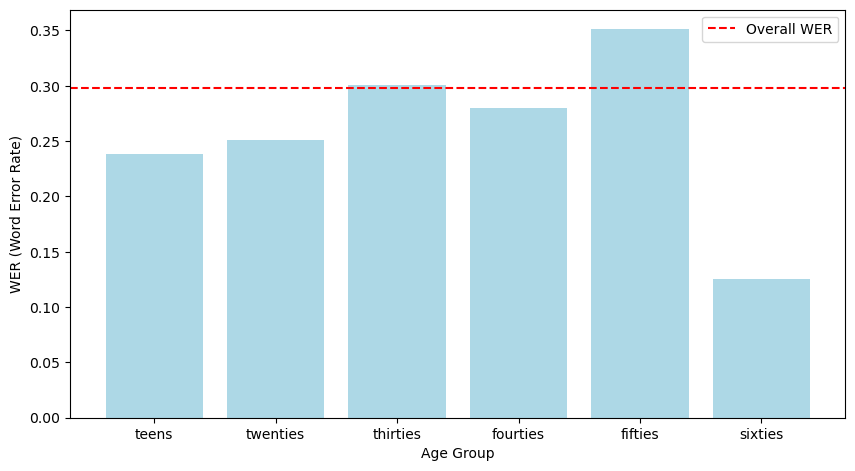

In [10]:
# Create a bar plot of WER for each age group
plt.figure(figsize=(10, 6))
plt.bar(age_grouped['age'], age_grouped['total_wer'], color='lightblue')

# Add a horizontal line to represent the 'Overall' median
overall_median = age_grouped_overall_total_wer
plt.axhline(overall_median, color='red', linestyle='--', label='Overall WER')

# Add labels 
plt.xlabel('Age Group')
plt.ylabel('WER (Word Error Rate)')

# Show the legend
plt.legend()

plt.subplots_adjust(bottom=0.2)
plt.xticks()

# Save the plot as a PNG file
plt.savefig('.\\summary\\plots\\age_group_wer.png')

# Show the plot
plt.show()

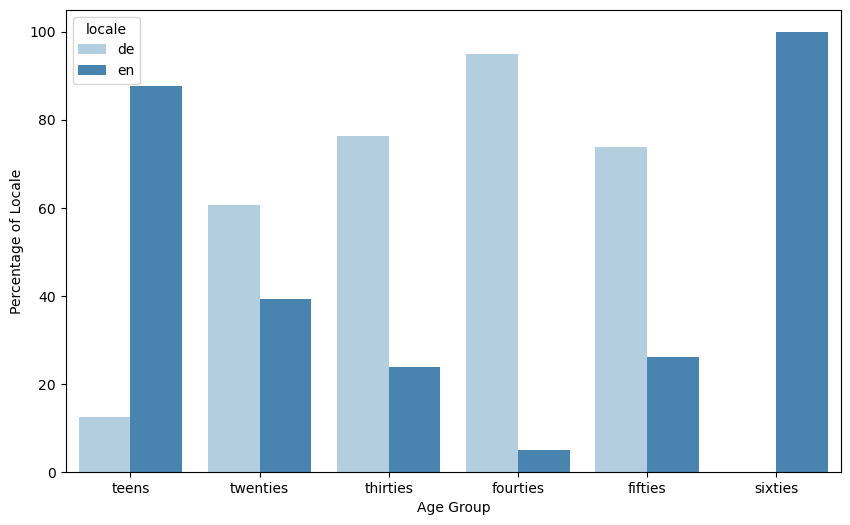

In [43]:
age_locale_grouped = cvtx.groupby(['age', 'locale']).size().reset_index(name='locale_amount')
# Calculate the percentage distribution of 'locale_amount' within each 'age' group
age_locale_grouped['percentage'] = age_locale_grouped.groupby('age')['locale_amount'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))

# Use seaborn's barplot function to create the plot
sns.barplot(x='age', y='percentage', data=age_locale_grouped, hue='locale', order=custom_order, palette='Blues')

# Customize the plot
plt.xlabel('Age Group')
plt.ylabel('Percentage of Locale')

plt.savefig('.\\summary\\plots\\age_locale_group.png')

# Show the plot
plt.show()

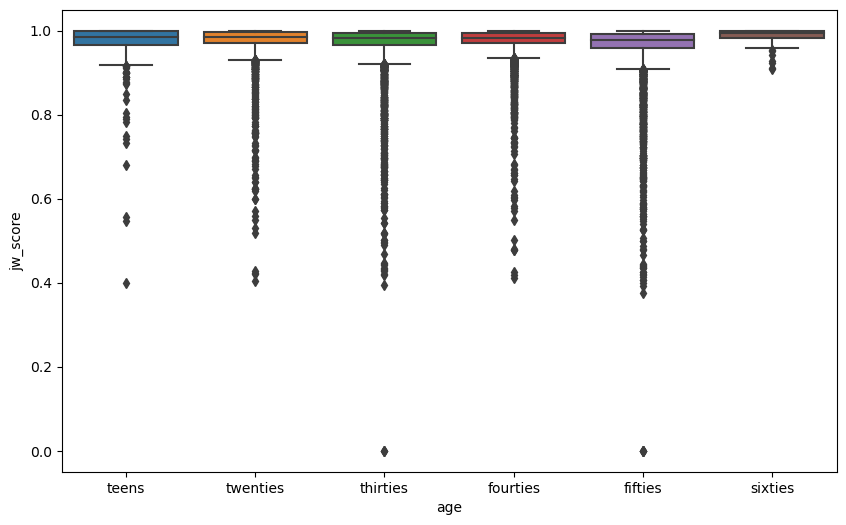

In [11]:
plt.figure(figsize=(10, 6))

custom_order = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties']

sns.boxplot(x ='age', y ='jw_score', data =cvtx, order=custom_order)
plt.xticks()

plt.savefig('.\\summary\\plots\\cvtx_age_jw_boxplot.png')
plt.show()

In [12]:
replacement_dict = {
    'german': ['Deutschland Deutsch', 
               'Bundesdeutsch, Hochdeutsch,Deutschland Deutsch,Nordrhein-Westfalen', 
               'Deutschland Deutsch,Hochdeutsch', 
               'Hochdeutsch'],
    'english (american)': ['United States English',  
                           'England English,United States English',  
                           'Mix of american and british accent', 
                           'Gay,United States English', 
                           'Central American ,United States English', 
                           'Mid-atlantic,United States English',      
                           'Born and lived in eastern VA for 8 years. Then lived in southern CA for 13 years.  Lived in MD, NC, WA, HI  for 1-3 years each.  Spent 30 years in Washington DC area and 17 years in Northern KY/Cincinnati OH area,United States English',   
                           'country,United States English', 
                           'English Second Language,United States English', 
                           'United States English,Western New England English'],
    'english (west-american)': ['Demure,Low,Midwestern,United States English', 
                                'United States English,United States, west coast English', 
                                'American Midwestern,United States English',
                                'United States English,United States-Midwestern,United States-West Coast-Alaska',
                                'Midwestern,United States English',
                                'United States English,West Coast',
                                'United States English,United States, west coast English '],
    'english (north-american)': ['Chicago ,Gen Z,Midwestern,United States English',
                                 'Minnesotan,United States English',
                                 'Northeast US,United States English'],
    'english (south-american)': ['East Texas,Texan,United States English',
                                 'Kentucky united states accent,southern usa,United States English',
                                 'kentucky,United States English'],
    'english (canadian)': ['Canadian English', 
                           'Canadian English,Ontario', 
                           'Canadian English,Pacific Northwest English', 
                           'Canadian English,United States English', 
                           'Canadian English,Welsh English'],
    'english': ['England English', 
                'Bedford English,Cambridge English,England English', 
                'England English,Received Pronunciation', 
                'Chichester'],
    'english (dialect)': ['England English,New Zealand English', 
                          'East Anglian English,England English', 
                          'England English,southern english,sussex', 
                          'Eastury English,England English', 
                          'East Midlands,Nottinghamshire'],
    'english (india and south asia)': ['India and South Asia (India, Pakistan, Sri Lanka)', 
                                       'India and South Asia (India, Pakistan, Sri Lanka),Singaporean English', 
                                       'Malaysian English', 
                                       'India and South Asia (India, Pakistan, Sri Lanka),United States English', 
                                      'I think mine accent is influenced by Indian Accent ,India and South Asia (India, Pakistan, Sri Lanka),Yes Please. ',
                                      'indian'],
    'german (austrian)': ['Österreichisches Deutsch', 
                          'Oberösterreichisches Deutsch,Österreichisches Deutsch'],
    'english (filipino)': ['Filipino', 
                           'Filipino,United States English', 
                           'Bisaya,Filipino'],
    'english (scottish)': ['Scottish English', 
                           'Glaswegian ,Scottish English'],
    'english (irish)': ['culchie,Northern Irish', 
                        'Irish English', 
                        'Northern Irish'],
    'english (australian)': ['Australian English', 
                             'South Australia', 
                             'Australian English,General Australian', 
                             'New Zealand English'],
    'german (french)': ['Belgisches Deutsch', 
                        'Belgisches Deutsch,Französisch Deutsch'],
    'english (israeli)': ['Israeli'],
    'german (swiss)': ['Schweizerdeutsch'],
    'german (dialect)': ['Deutschland Deutsch,Norddeutsch', 
                         'Kraichgauer',  
                         'Rheinländich', 
                         'Süddeutsch', 
                         'Deutschland Deutsch Fränkisch', 
                         'Deutschland Deutsch,Kraichgauer,Odenwälder'],
    'english (african)': ['Kenyan English accent', 
                          'East African Khoja', 
                          'Southern African (South Africa, Zimbabwe, Namibia)', 
                          'black,male,Southern African (South Africa, Zimbabwe, Namibia),Xhosa', 
                          'Durban,Southern African (South Africa, Zimbabwe, Namibia)', 
                          'England English,Southern African (South Africa, Zimbabwe, Namibia)', 
                          'Southern African (South Africa, Zimbabwe, Namibia),United States English'],
    'german (english)': ['Amerikanisches Deutsch', 
                         'Britisches Deutsch'],
    'english (german)': ['German English,Non native speaker', 
                         'German', 
                         'denglish,German English'],
    'english (central-european)': ['Generic European', 
                                   'European English',  
                                   'Slight Dutch accent,United States English', 
                                   'Dutch,United States English', 
                                   'Western Europe'],
    'english (east-european)': ['Ukrainian', 
                                'Czech',
                                'Hunglish', 
                                'Russian',
                                'Czech accent',
                                'England English,Polish English',
                                'Australian English,Russian,Ukrainian'],
    'english (asian-american)': ['Asian-American English,United States English', 
                                 'Chinese English', 
                                 'Chinese', 
                                 'Hong Kong English,United States English', 
                                 'Indonesian'],
    'german(east-european)': ['Polnisch Deutsch', 
                              'Ungarisch Deutsch', 
                              'Ruhrdeutsch,Ungarisch Deutsch'],
    'english (hispanic)': ['Hispanic'],
    'german (asian)': ['Chinesisch Deutsch'],
    'english (french)': ['Haitian Creole', 
                         'french accent', 
                         'French'],
    'english (other)': ['England English,Swedish', 
                        'West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad)', 
                        'Brazilian', 
                        'Egyptian', 
                        'Turkish', 
                        'English (Native Greek speaker)', 
                        'english norwegian',
                        'Scandinavian,United States English']
}

# Loop through the dictionary and perform replacements
for key, values_to_replace in replacement_dict.items():
    cvtx['accents'] = cvtx['accents'].replace(values_to_replace, key)

In [13]:
accents_grouped = cvtx.groupby('accents')[['Errors', 'Reference_Length']].sum()

accents_grouped['total_wer'] = accents_grouped['Errors'] / accents_grouped['Reference_Length']

# Define the custom order of the index values
custom_order = ['german', 
                'german (dialect)', 
                'german (austrian)', 
                'german (swiss)', 
                'german(east-european)', 
                'german (french)', 
                'german (asian)', 
                'german (english)', 
                'english (american)',
                'english (south-american)',
                'english (west-american)',
                'english (north-american)',
                'english (hispanic)',
                'english (canadian)',
                'english',
                'english (dialect)',
                'english (irish)',
                'english (scottish)',
                'english (australian)',
                'english (east-european)',
                'english (central-european)',
                'english (french)',
                'english (german)',
                'english (israeli)',
                'english (asian-american)',
                'english (india and south asia)',
                'english (filipino)',
                'english (african)',
                'english (other)']


accents_grouped = accents_grouped.reindex(custom_order)
accents_grouped.reset_index(inplace=True)

total_errors = accents_grouped['Errors'].sum()
total_reference_length = accents_grouped['Reference_Length'].sum()

accents_grouped_overall_total_wer = total_errors / total_reference_length

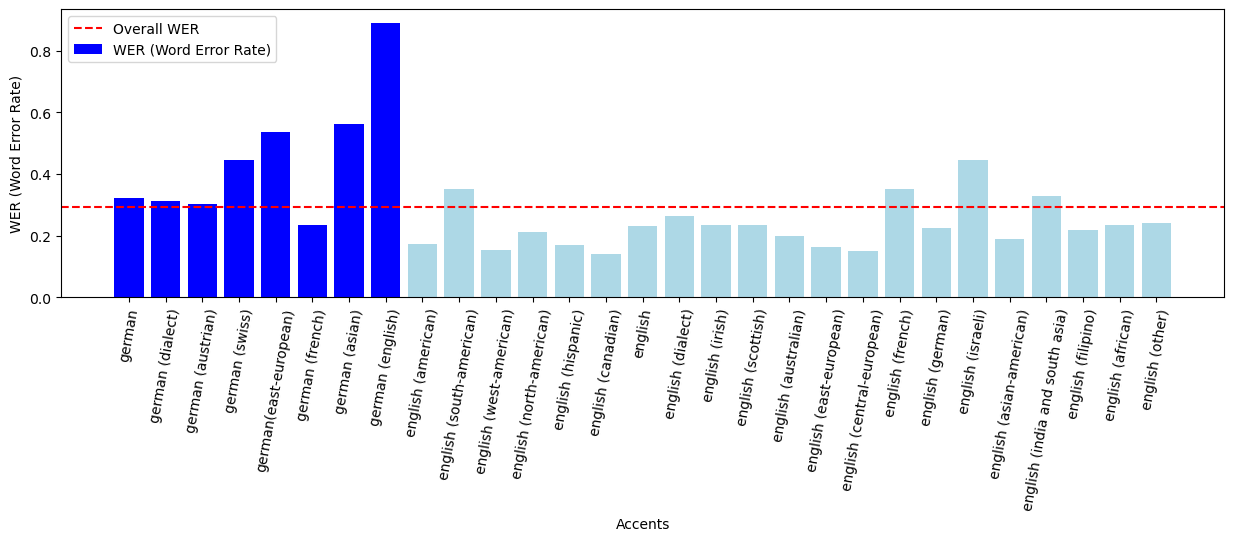

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 6))

colors = ['blue' if accent.startswith('german') else 'lightblue' for accent in accents_grouped['accents']]
ax1.bar(accents_grouped['accents'], accents_grouped['total_wer'], color=colors, label='WER (Word Error Rate)')

ax1.set_xlabel('Accents')
ax1.set_ylabel('WER (Word Error Rate)')

overall_median = accents_grouped_overall_total_wer
ax1.axhline(overall_median, color='red', linestyle='--', label='Overall WER')

ax1.legend(loc='upper left')
plt.subplots_adjust(bottom=0.4)
plt.xticks(rotation=80)

plt.savefig('.\\summary\\plots\\accents_wer.png')

plt.show()

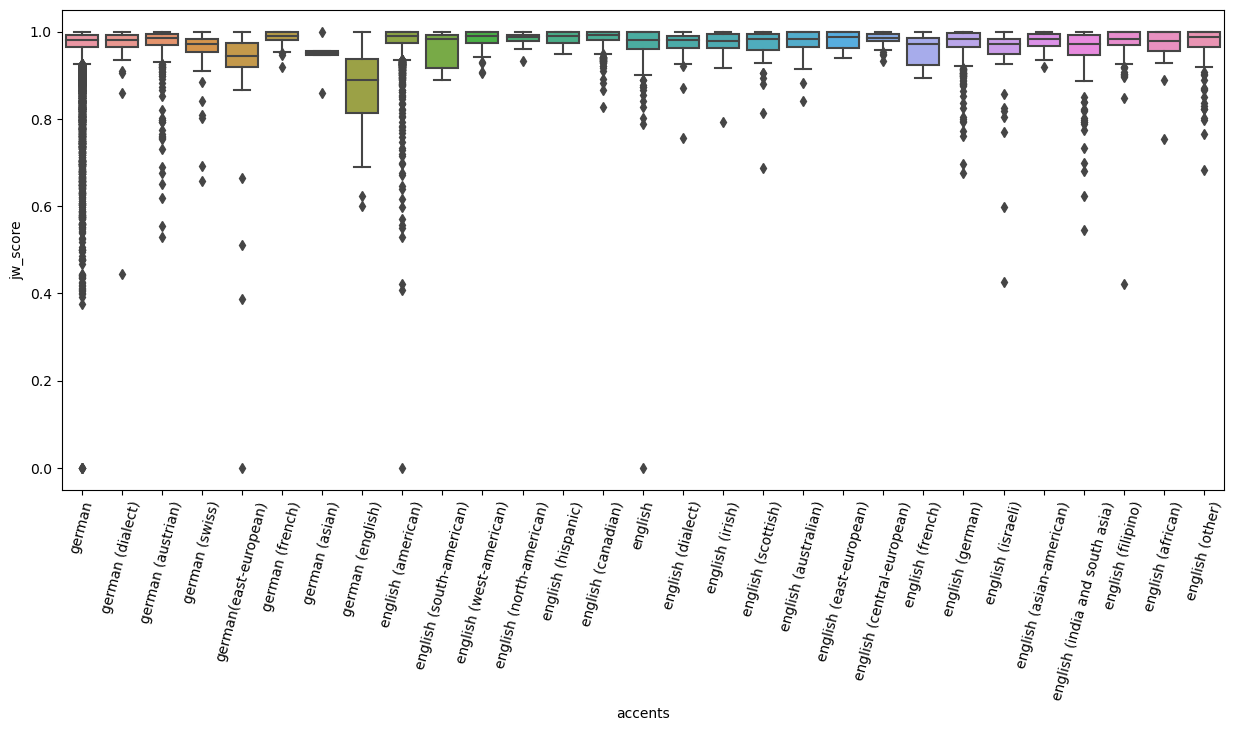

In [15]:
plt.figure(figsize=(15, 10))


custom_order = ['german', 
                'german (dialect)', 
                'german (austrian)', 
                'german (swiss)', 
                'german(east-european)', 
                'german (french)', 
                'german (asian)', 
                'german (english)', 
                'english (american)',
                'english (south-american)',
                'english (west-american)',
                'english (north-american)',
                'english (hispanic)',
                'english (canadian)',
                'english',
                'english (dialect)',
                'english (irish)',
                'english (scottish)',
                'english (australian)',
                'english (east-european)',
                'english (central-european)',
                'english (french)',
                'english (german)',
                'english (israeli)',
                'english (asian-american)',
                'english (india and south asia)',
                'english (filipino)',
                'english (african)',
                'english (other)']


sns.boxplot(x ='accents', y ='jw_score', data =cvtx, order=custom_order)
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.4)

plt.savefig('.\\summary\\plots\\cvtx_jw_boxplot.png')
plt.show()

In [16]:
# Create a dictionary to map the first three letters to groups
group_mapping = {
    'POD': 'Podcast',
    'AUD': 'Audiobook',
    'YOU': 'Youtube'
}

# Apply the mapping to create a new column 'Source'
gstx['Source'] = gstx['segment_id'].str[:3].map(group_mapping)

# Group the DataFrame by 'age' and calculate the sum of 'errors' and 'words' in each group
source_grouped = gstx.groupby('Source')[['Errors', 'Reference_Length']].sum()

# Calculate the WER for each age group
source_grouped['total_wer'] = source_grouped['Errors'] / source_grouped['Reference_Length']

# Reset the index to make 'age' a regular column
source_grouped.reset_index(inplace=True)

total_errors = source_grouped['Errors'].sum()
total_reference_length = source_grouped['Reference_Length'].sum()

# Calculate the overall total WER
source_grouped_overall_total_wer = total_errors / total_reference_length

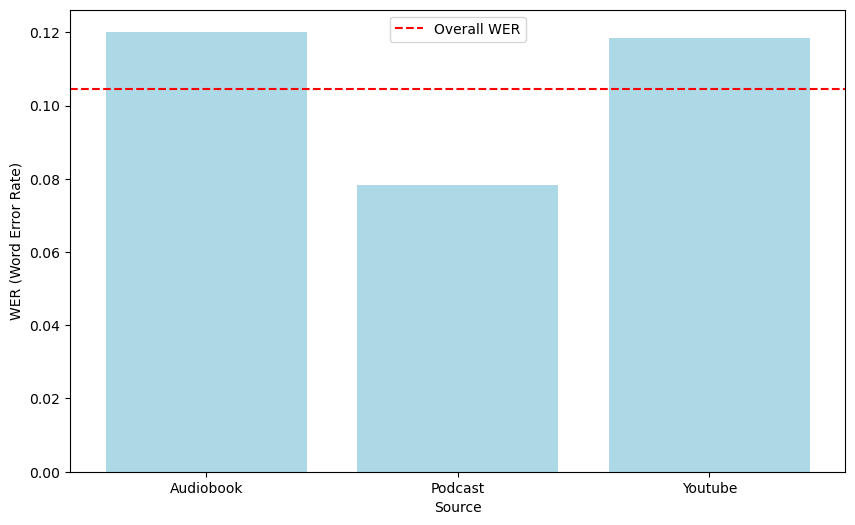

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(source_grouped['Source'], source_grouped['total_wer'], color='lightblue')

overall_median = source_grouped_overall_total_wer
plt.axhline(overall_median, color='red', linestyle='--', label='Overall WER')

plt.xlabel('Source')
plt.ylabel('WER (Word Error Rate)')

plt.legend()

plt.savefig('.\\summary\\plots\\source_group_wer.png')

plt.show()

In [18]:
category_grouped = gstx.groupby('category')[['Errors', 'Reference_Length']].sum()

# Calculate the WER for each age group
category_grouped['total_wer'] = category_grouped['Errors'] / category_grouped['Reference_Length']

# Reset the index to make 'age' a regular column
category_grouped.reset_index(inplace=True)

total_errors = category_grouped['Errors'].sum()
total_reference_length = category_grouped['Reference_Length'].sum()

# Calculate the overall total WER
category_grouped_overall_total_wer = total_errors / total_reference_length

In [19]:
# category labels
label_list = ["People and Blogs", 
              "Business", 
              "Nonprofits and Activism", 
              "Crime", 
              "History", 
              "Pets and Animals", 
              "News and Politics", 
              "Travel and Events", 
              "Kids and Family", 
              "Leisure", 
              "N/A", 
              "Comedy", 
              "News and Politics", 
              "Sports", 
              "Arts", 
              "Science and Technology", 
              "Autos and Vehicles", 
              "Science and Technology", 
              "People and Blogs", 
              "Music", 
              "Society and Culture", 
              "Education", 
              "Howto and Style", 
              "Film and Animation", 
              "Gaming", 
              "Entertainment", 
              "Travel and Events", 
              "Health and Fitness", 
              "audiobook"]

# Create a dictionary to map category numbers to labels
category_mapping = {index: label for index, label in enumerate(label_list)}

category_grouped['category'] = category_grouped['category'].map(category_mapping)
gstx['category'] = gstx['category'].map(category_mapping)

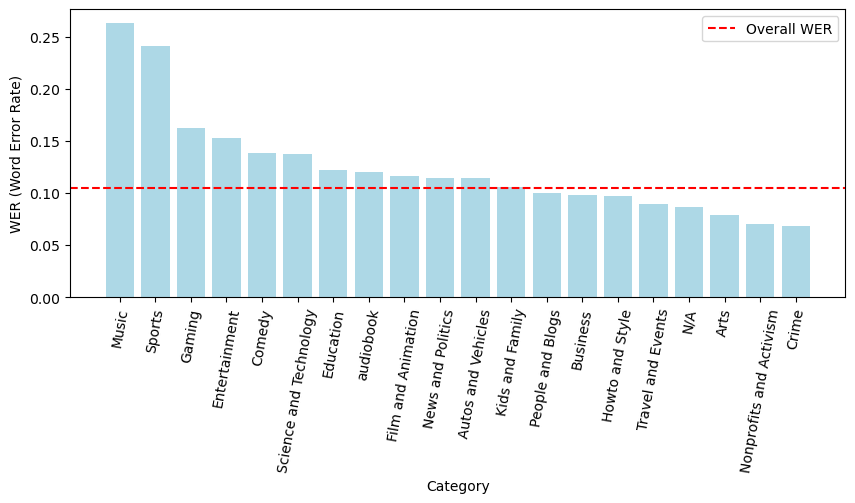

In [20]:
plt.figure(figsize=(10, 6))
category_grouped = category_grouped.sort_values(by='total_wer', ascending=False)
plt.bar(category_grouped['category'], category_grouped['total_wer'], color='lightblue')

overall_median = category_grouped_overall_total_wer
plt.axhline(overall_median, color='red', linestyle='--', label='Overall WER')

plt.xlabel('Category')
plt.ylabel('WER (Word Error Rate)')

plt.legend()
plt.subplots_adjust(bottom=0.4)
plt.xticks(rotation=80)

plt.savefig('.\\summary\\plots\\category_group_wer.png')

plt.show()

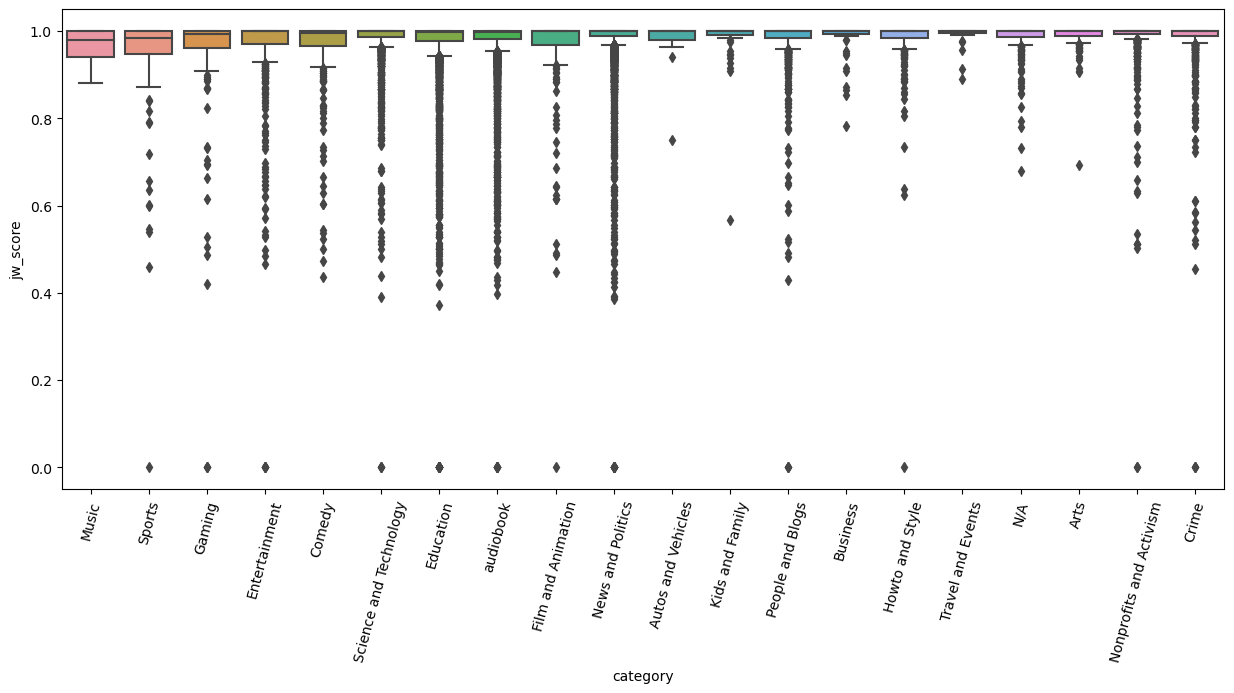

In [21]:
plt.figure(figsize=(15, 10))

custom_order = ['Music',
                'Sports',
                'Gaming',
                'Entertainment',
                'Comedy',
                'Science and Technology',
                'Education',
                'audiobook',
                'Film and Animation',
                'News and Politics',
                'Autos and Vehicles',
                'Kids and Family',
                'People and Blogs',
                'Business',
                'Howto and Style',
                'Travel and Events',
                'N/A',
                'Arts',
                'Nonprofits and Activism',
                'Crime']
sns.boxplot(x='category', y='jw_score', data=gstx, order=custom_order)
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.4)

plt.savefig('.\\summary\\plots\\gstx_jw_boxplot.png')
plt.show()

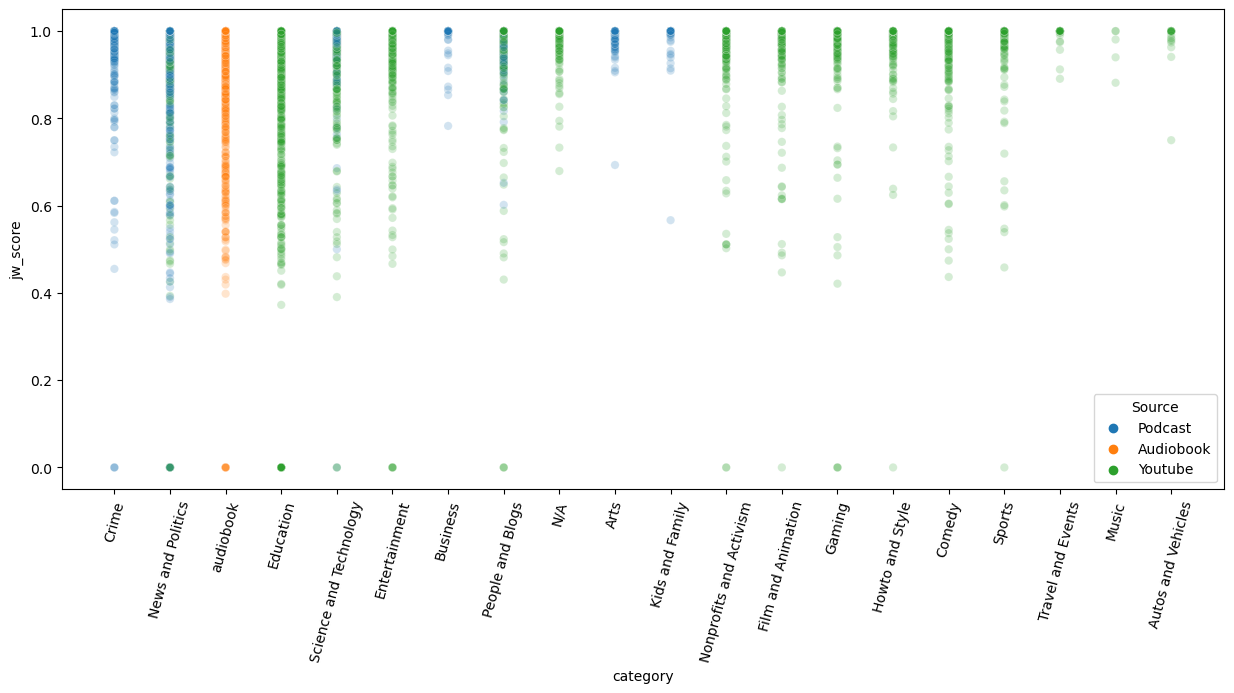

In [22]:
plt.figure(figsize=(15, 10))

custom_order = ['Music',
                'Sports',
                'Gaming',
                'Entertainment',
                'Comedy',
                'Science and Technology',
                'Education',
                'audiobook',
                'Film and Animation',
                'News and Politics',
                'Autos and Vehicles',
                'Kids and Family',
                'People and Blogs',
                'Business',
                'Howto and Style',
                'Travel and Events',
                'N/A',
                'Arts',
                'Nonprofits and Activism',
                'Crime']

sns.scatterplot(x='category', y='jw_score', hue='Source', data=gstx, alpha=0.2)
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.4)

plt.savefig('.\\summary\\plots\\gstx_jw_scatterplot.png')
plt.show()

In [23]:
only_science = gstx[gstx['category'] == 'Science and Technology']

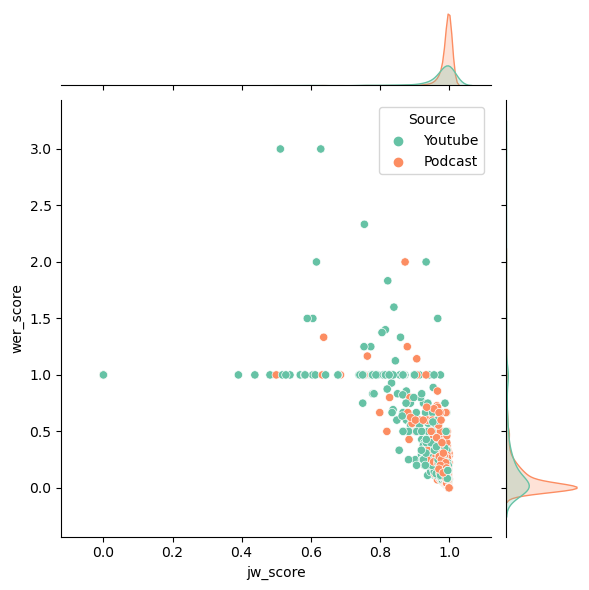

In [25]:
sns.jointplot(x='jw_score', y='wer_score', hue='Source', palette='Set2', data=only_science)

plt.savefig('.\\summary\\plots\\science_podcast_plot.png')
plt.show()

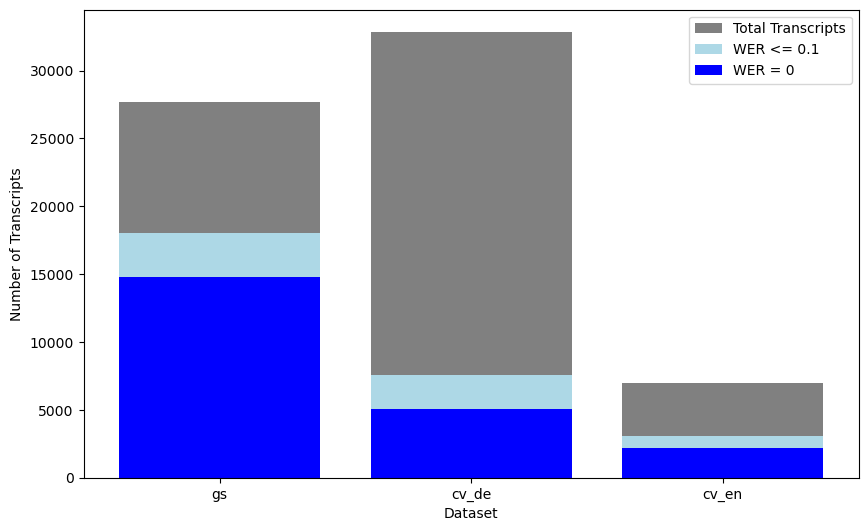

In [26]:
summary = summary.sort_values(by='Transcripts_WER=0', ascending=False)

plt.figure(figsize=(10, 6))

# Plot the total number of transcripts
plt.bar(summary['Dataset'], summary['Total_Transcripts'], color='grey', label='Total Transcripts')

# Plot transcripts with WER <= 0.1 as an overlay
plt.bar(summary['Dataset'], summary['Transcripts_WER<=0.1'], color='lightblue', label='WER <= 0.1')

# Plot transcripts with WER = 0 as an overlay
plt.bar(summary['Dataset'], summary['Transcripts_WER=0'], color='blue', label='WER = 0')

plt.xlabel('Dataset')
plt.ylabel('Number of Transcripts')
plt.legend()

plt.subplots_adjust(bottom=0.1)

plt.savefig('.\\summary\\plots\\dataset_comparison_wer.png')

plt.show()

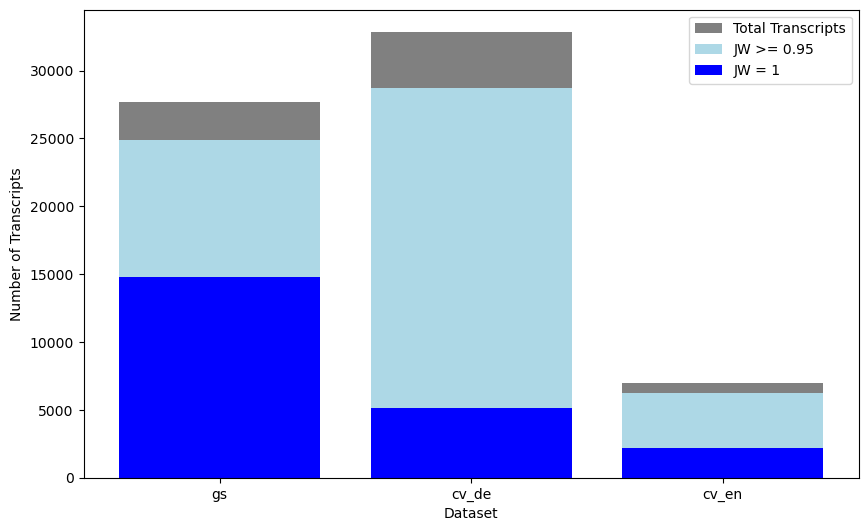

In [27]:
summary = summary.sort_values(by='Transcripts_JW=1', ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(summary['Dataset'], summary['Total_Transcripts'], color='grey', label='Total Transcripts')
plt.bar(summary['Dataset'], summary['Transcripts_JW>=0.95'], color='lightblue', label='JW >= 0.95')
plt.bar(summary['Dataset'], summary['Transcripts_JW=1'], color='blue', label='JW = 1')

plt.xlabel('Dataset')
plt.ylabel('Number of Transcripts')
plt.legend()

plt.subplots_adjust(bottom=0.1)

plt.savefig('.\\summary\\plots\\dataset_comparison_jw.png')

plt.show()

In [28]:
cv_de_mcx = cv_de_mcx[['run', 'path', 'wer_score', 'jw_score']]

client_id_map = {'sample_01' : 'common_voice_de_36849367.mp3',
                 'sample_02' : 'common_voice_de_37200806.mp3',
                 'sample_03' : 'common_voice_de_36979516.mp3',
                 'sample_04' : 'common_voice_de_36893955.mp3',
                 'sample_05' : 'common_voice_de_37017387.mp3',
                 'sample_06' : 'common_voice_de_36844784.mp3',
                 'sample_07' : 'common_voice_de_37267452.mp3',
                 'sample_08' : 'common_voice_de_37265339.mp3',
                 'sample_09' : 'common_voice_de_36858871.mp3',
                 'sample_10' : 'common_voice_de_37112722.mp3'}

for key, values_to_replace in client_id_map.items():
    cv_de_mcx['path'] = cv_de_mcx['path'].replace(values_to_replace, key)

C:\Users\robin\AppData\Local\Temp\ipykernel_18372\2990084094.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_de_mcx['path'] = cv_de_mcx['path'].replace(values_to_replace, key)


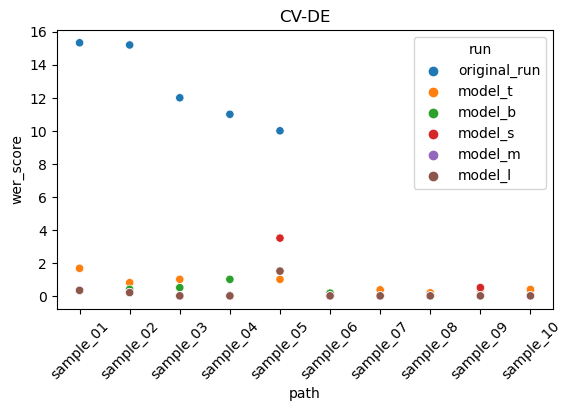

In [29]:
sns.scatterplot(x='path', y='wer_score', data=cv_de_mcx, hue='run')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.3)
plt.title('CV-DE')
plt.savefig('.\\summary\\plots\\cv_de_mcx_wer_scatterplot.png')
plt.show()

In [30]:
cv_en_mcx = cv_en_mcx[['run', 'path', 'wer_score', 'jw_score']]

client_id_map = {'sample_01' : 'common_voice_en_37256826.mp3',
                 'sample_02' : 'common_voice_en_36537239.mp3',
                 'sample_03' : 'common_voice_en_37280831.mp3',
                 'sample_04' : 'common_voice_en_36998293.mp3',
                 'sample_05' : 'common_voice_en_37034152.mp3',
                 'sample_06' : 'common_voice_en_36613124.mp3',
                 'sample_07' : 'common_voice_en_36800636.mp3',
                 'sample_08' : 'common_voice_en_36735274.mp3',
                 'sample_09' : 'common_voice_en_36735247.mp3',
                 'sample_10' : 'common_voice_en_36735292.mp3'}

for key, values_to_replace in client_id_map.items():
    cv_en_mcx['path'] = cv_en_mcx['path'].replace(values_to_replace, key)

C:\Users\robin\AppData\Local\Temp\ipykernel_18372\3517467297.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv_en_mcx['path'] = cv_en_mcx['path'].replace(values_to_replace, key)


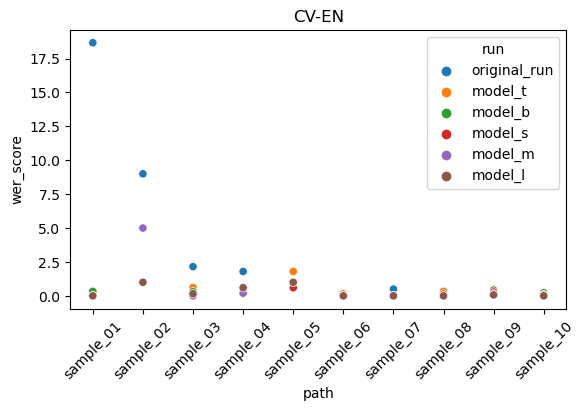

In [32]:
sns.scatterplot(x='path', y='wer_score', data=cv_en_mcx, hue='run')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.3)

plt.title('CV-EN')
plt.savefig('.\\summary\\plots\\cv_en_mcx_wer_scatterplot.png')
plt.show()

In [33]:
gs_mcx = gs_mcx[['run', 'path', 'wer_score', 'jw_score']]

client_id_map = {'sample_01' : 'AUD0000000007_S0001775.wav',
                 'sample_02' : 'YOU0000001377_S0000252.wav',
                 'sample_03' : 'YOU0000000171_S0006276.wav',
                 'sample_04' : 'YOU0000000549_S0000076.wav',
                 'sample_05' : 'POD0000005244_S0000045.wav',
                 'sample_06' : 'AUD0000000012_S0000551.wav',
                 'sample_07' : 'YOU0000003946_S0000146.wav',
                 'sample_08' : 'POD0000001424_S0000430.wav',
                 'sample_09' : 'YOU0000005628_S0000078.wav',
                 'sample_10' : 'AUD0000000515_S0001078.wav'}

for key, values_to_replace in client_id_map.items():
    gs_mcx['path'] = gs_mcx['path'].replace(values_to_replace, key)

C:\Users\robin\AppData\Local\Temp\ipykernel_18372\438287204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_mcx['path'] = gs_mcx['path'].replace(values_to_replace, key)


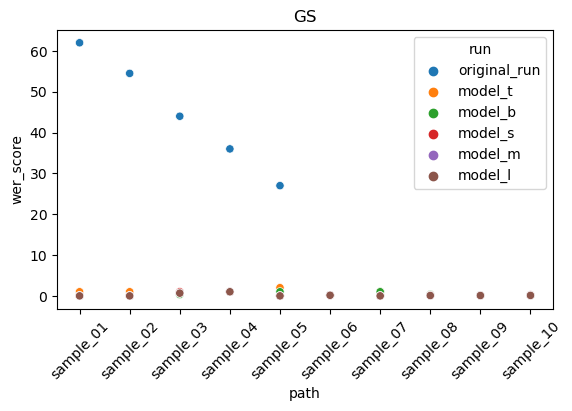

In [35]:
sns.scatterplot(x='path', y='wer_score', data=gs_mcx, hue='run')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.3)

plt.title('GS')
plt.savefig('.\\summary\\plots\\gs_mcx_wer_scatterplot.png')
plt.show()

In [36]:
pos_count_insertions = pos_count[['Part of Speech','cv_de_insertion_pos','cv_en_insertion_pos', 'gs_insertion_pos']].copy()
pos_count_insertions.rename(columns = {'cv_de_insertion_pos': 'cv_de', 'cv_en_insertion_pos': 'cv_en', 'gs_insertion_pos': 'gs'}, inplace=True)
pos_count_deletions = pos_count[['Part of Speech','cv_de_deletion_pos','cv_en_deletion_pos', 'gs_deletion_pos']].copy()
pos_count_deletions.rename(columns = {'cv_de_deletion_pos': 'cv_de', 'cv_en_deletion_pos': 'cv_en', 'gs_deletion_pos': 'gs'}, inplace=True)
pos_count_og_words = pos_count[['Part of Speech','cv_de_og_word_pos','cv_en_og_word_pos', 'gs_og_word_pos']].copy()
pos_count_og_words.rename(columns = {'cv_de_og_word_pos': 'cv_de', 'cv_en_og_word_pos': 'cv_en', 'gs_og_word_pos': 'gs'}, inplace=True)

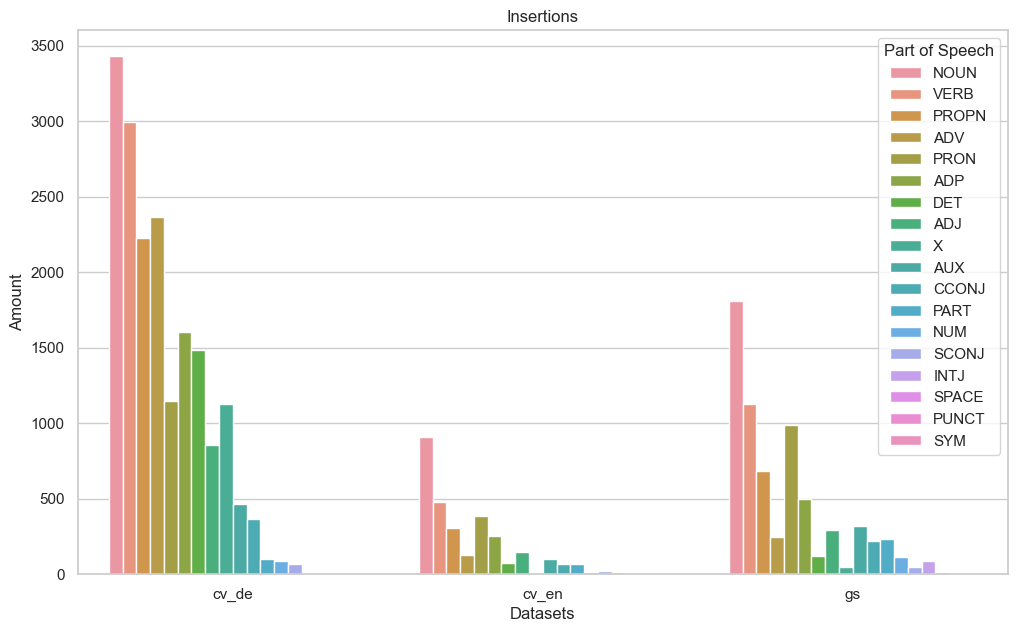

In [37]:
# Melt the DataFrame to reshape it for Seaborn
melted_df = pos_count_insertions.melt(id_vars=['Part of Speech'], var_name='Column Name', value_name='Amount')

hue_order = melted_df.groupby('Part of Speech')['Amount'].sum().sort_values(ascending=False).index

# create a grid behind bars
sns.set(style="whitegrid")
# Create a bar plot
plt.figure(figsize=(12, 8)) 
sns.barplot(data=melted_df, x='Column Name', y='Amount', hue='Part of Speech', hue_order=hue_order)
plt.xlabel('Datasets')
plt.ylabel('Amount')
plt.subplots_adjust(bottom=0.2)
plt.xticks() 
plt.legend(title='Part of Speech')
plt.title('Insertions')
plt.savefig('.\\summary\\plots\\pos_count_insertions.png')
plt.show()

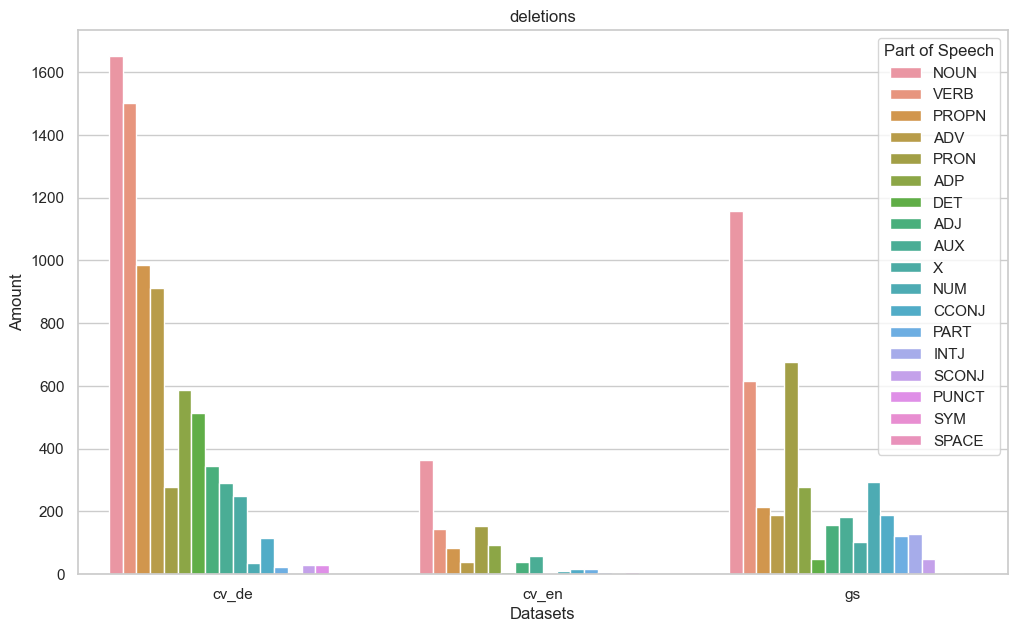

In [38]:
melted_df = pos_count_deletions.melt(id_vars=['Part of Speech'], var_name='Column Name', value_name='Amount')
hue_order = melted_df.groupby('Part of Speech')['Amount'].sum().sort_values(ascending=False).index

plt.figure(figsize=(12, 8)) 
sns.barplot(data=melted_df, x='Column Name', y='Amount', hue='Part of Speech', hue_order=hue_order)
plt.xlabel('Datasets')
plt.ylabel('Amount')
plt.subplots_adjust(bottom=0.2)
plt.xticks() 
plt.legend(title='Part of Speech')

plt.title('deletions')
plt.savefig('.\\summary\\plots\\pos_count_deletions.png')
plt.show()

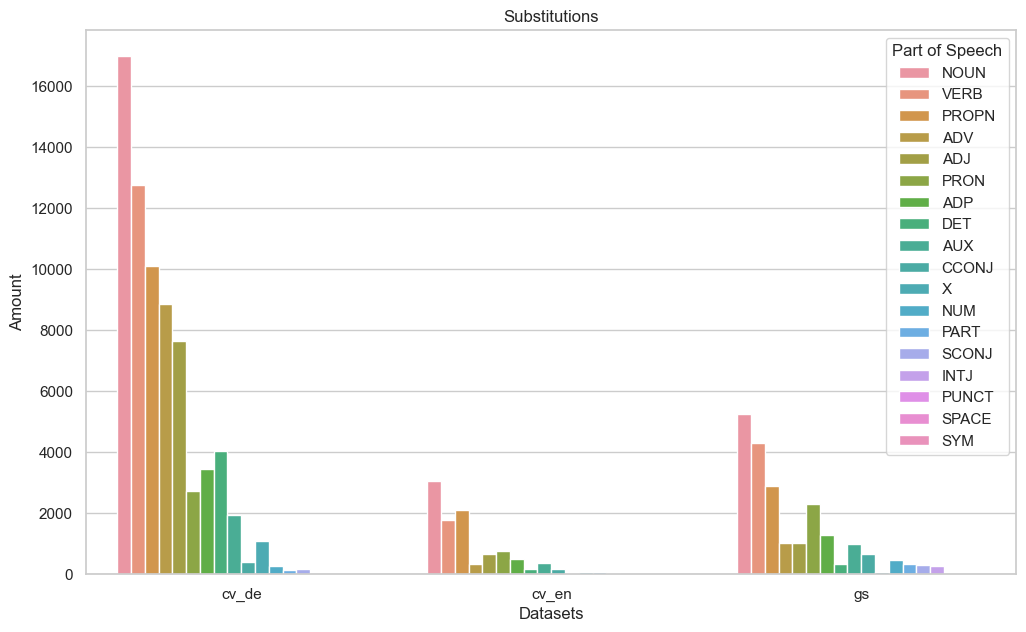

In [39]:
melted_df = pos_count_og_words.melt(id_vars=['Part of Speech'], var_name='Column Name', value_name='Amount')
hue_order = melted_df.groupby('Part of Speech')['Amount'].sum().sort_values(ascending=False).index

plt.figure(figsize=(12, 8)) 
sns.barplot(data=melted_df, x='Column Name', y='Amount', hue='Part of Speech', hue_order=hue_order)
plt.xlabel('Datasets')
plt.ylabel('Amount')
plt.subplots_adjust(bottom=0.2)
plt.xticks() 
plt.legend(title='Part of Speech')

plt.title('Substitutions')
plt.savefig('.\\summary\\plots\\pos_count_og_words.png')
plt.show()